# Introduction

This code attempts to determine the pdfs and cdfs for charging events in the NREL EV Dataset. The code is not vectorized and should be refactored before final publication. There is also a matter of the spurious charging events that last $\leq 2$ samples. These will affect the start time pdf. However, before work is done to remove these points, statistical testing should be done to see if it significantly affects use for the Grid study

## Charging Classification

The electric vehicle charging events in the NREL dataset can be considered a multivariable stochastic process, $X = \{X_0, X_1 ... X_{348}\}$. TODO: Describe the mathematical treatment in greater detail

In [64]:
import matplotlib
import pandas as pd
import numpy as np
import pickle
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mpl_dates
plt.rcParams.update({'font.size':14})
import matplotlib.gridspec as gridspec
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 200

In [2]:
df = pd.read_csv('PEV-Profiles-L1.csv')

In [3]:
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time',inplace=True)

In [4]:
df.head()

,Vehicle 1,Vehicle 2,Vehicle 3,Vehicle 4,Vehicle 5,Vehicle 6,Vehicle 7,Vehicle 8,Vehicle 9,Vehicle 10,...,Vehicle 339,Vehicle 340,Vehicle 341,Vehicle 342,Vehicle 343,Vehicle 344,Vehicle 345,Vehicle 346,Vehicle 347,Vehicle 348
Time,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 00:10:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 00:20:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 00:30:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 00:40:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Feature Engineering

## Obtaining daily charging events and their start times

The dataset is reduced to one vehicle for a proof of concept. The charging events of the vehicle is determined based on whether there is a change in value from 0 to 1920 W. This introduces some inaccuracy since there will be events where the vehicle stops and starts charging during a charging cycle. This can be addressed in preprocessing if time allows.

In [6]:
def count_charging_events(df,vcl_id):
    '''
    Iterate though df getting charging periods and adding them to an np.array
    This is a dumb fucking idea and should be modified to scale better.
    Consider a classification or change-point detection approach
    '''
    charging_times = np.array([0,0],ndmin=2)
    charge_start = charge_stop = 0
    was_charging = False
    curr_charging = False
    
    for index, element in df.iterrows():
        val = element[vcl_id]
        #numpy_index = pd.to_numpy(index)
        numpy_index = index
        #print(val)
        if val > 0:
            curr_charging = True
            if was_charging == False:
                charge_start = numpy_index
                was_charging = True
        elif val == 0:
            curr_charging = False
            if was_charging == True:
                charge_stop = numpy_index
                #print()
                #charging_times.append([charge_start,charge_stop])
                charging_times = np.append(charging_times,[[charge_start,charge_stop]],axis=0)
                was_charging = False
        #print(charging_times)
        
    charging_times = np.delete(charging_times,[0,0],axis=0)
    return charging_times
    
        

In [7]:
sample = df[['Vehicle 1']]
sample

,Vehicle 1
Time,
2010-01-01 00:00:00,0
2010-01-01 00:10:00,0
2010-01-01 00:20:00,0
2010-01-01 00:30:00,0
2010-01-01 00:40:00,0
...,...
2010-12-31 23:10:00,0
2010-12-31 23:20:00,0
2010-12-31 23:30:00,0


In [13]:
ctimes = count_charging_events(sample,'Vehicle 1')

In [14]:
ctimes

array([[Timestamp('2010-01-01 11:30:00'),
        Timestamp('2010-01-01 13:30:00')],
       [Timestamp('2010-01-02 11:30:00'),
        Timestamp('2010-01-02 12:10:00')],
       [Timestamp('2010-01-05 16:40:00'),
        Timestamp('2010-01-05 18:10:00')],
       ...,
       [Timestamp('2010-12-30 14:30:00'),
        Timestamp('2010-12-30 15:20:00')],
       [Timestamp('2010-12-31 01:40:00'),
        Timestamp('2010-12-31 02:40:00')],
       [Timestamp('2010-12-31 14:40:00'),
        Timestamp('2010-12-31 15:40:00')]], dtype=object)

In [28]:
start_times = [x[0] for x in ctimes]
start_times

[Timestamp('2010-01-01 11:30:00'),
 Timestamp('2010-01-02 11:30:00'),
 Timestamp('2010-01-05 16:40:00'),
 Timestamp('2010-01-05 20:20:00'),
 Timestamp('2010-01-06 20:10:00'),
 Timestamp('2010-01-07 13:40:00'),
 Timestamp('2010-01-08 09:40:00'),
 Timestamp('2010-01-08 13:30:00'),
 Timestamp('2010-01-08 19:40:00'),
 Timestamp('2010-01-09 11:00:00'),
 Timestamp('2010-01-09 18:30:00'),
 Timestamp('2010-01-10 10:50:00'),
 Timestamp('2010-01-10 12:30:00'),
 Timestamp('2010-01-10 18:50:00'),
 Timestamp('2010-01-10 19:30:00'),
 Timestamp('2010-01-11 20:50:00'),
 Timestamp('2010-01-12 01:40:00'),
 Timestamp('2010-01-12 11:00:00'),
 Timestamp('2010-01-12 22:30:00'),
 Timestamp('2010-01-14 10:30:00'),
 Timestamp('2010-01-14 15:20:00'),
 Timestamp('2010-01-14 17:20:00'),
 Timestamp('2010-01-15 18:20:00'),
 Timestamp('2010-01-16 17:10:00'),
 Timestamp('2010-01-17 08:20:00'),
 Timestamp('2010-01-17 18:00:00'),
 Timestamp('2010-01-18 12:10:00'),
 Timestamp('2010-01-18 16:50:00'),
 Timestamp('2010-01-

In [55]:
# yr_test = start_times[0].year
# mth_test = start_times[0].month
# day_test = start_times[0].day
# start_times[0] - pd.Timestamp(year=yr_test,month=mth_test,day=day_test,hour=0)
#yr_test
#start_times[0] - pd.Timestamp(year=,month=,day=,hour=0)

def get_time(Timestamp_fmt):
    yr_test = Timestamp_fmt.year
    mth_test = Timestamp_fmt.month
    day_test = Timestamp_fmt.day
    return Timestamp_fmt - pd.Timestamp(year=yr_test,month=mth_test,day=day_test,hour=0)


# TODO: Create an array with pure times based on time difference 0H and timestamp
fmt_start_times = list(map(get_time,start_times))
fmt_start_times = list(map(lambda x:x.total_seconds(),fmt_start_times))
#fmt_start_times = pd.Series(start_times).apply()

Text(0, 0.5, 'Frequency')

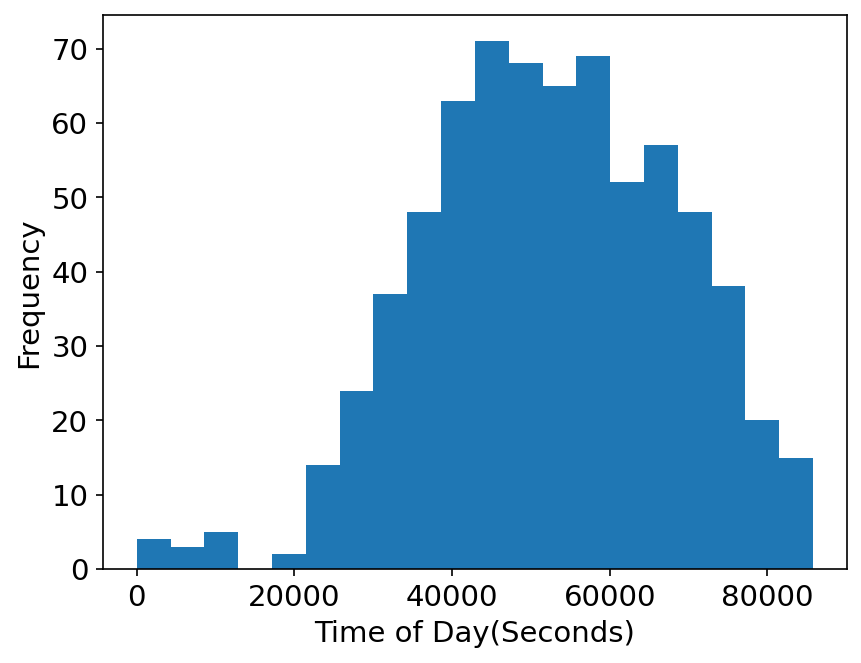

In [74]:
matplotlib.rcParams["figure.dpi"] = 150
plt.hist(fmt_start_times,bins=20)
plt.xlabel('Time of Day(Seconds)')
plt.ylabel('Frequency')

#fmt_start_times[0]

In [72]:
#isolating time aspect of charging events
durations = pd.Series([ v2 - v1 for v1, v2 in ctimes])
fmt_duration_times = list(map(lambda x:x.total_seconds(),durations)) #determining charging even durations in seconds

In [73]:
fmt_duration_times[0]

7200.0

## Extending Feature Engineering to entire data set

The methods used above for one vehicle will be done on the entire dataset and then joined to produce an aggregated series.

In [77]:
len(df.columns)

348

In [85]:
%%timeit
agg_ctimes_lm = [count_charging_events(df,x) for x in df.columns[0:2]]

5.76 s ± 416 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
%%timeit
agg_ctimes_pd = list(map(lambda x:count_charging_events(df,x),df.columns[0:2]))

5.8 s ± 529 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [89]:
#agg_ctimes = [count_charging_events(df,x) for x in df.columns] LONG RUN TIME

In [92]:
#len(agg_ctimes) #checking if all vehicles analyzed

348

In [94]:
# Serializing charging events due to the long run time
# with open("agg_ctimes.pickle", "wb") as outfile:
#     pickle.dump(agg_ctimes, outfile)

In [95]:
# Deserialization
with open("agg_ctimes.pickle", "rb") as infile:
    agg_ctimes_dspkl = pickle.load(infile)

In [96]:
agg_ctimes_dspkl

[array([[Timestamp('2010-01-01 11:30:00'),
         Timestamp('2010-01-01 13:30:00')],
        [Timestamp('2010-01-02 11:30:00'),
         Timestamp('2010-01-02 12:10:00')],
        [Timestamp('2010-01-05 16:40:00'),
         Timestamp('2010-01-05 18:10:00')],
        ...,
        [Timestamp('2010-12-30 14:30:00'),
         Timestamp('2010-12-30 15:20:00')],
        [Timestamp('2010-12-31 01:40:00'),
         Timestamp('2010-12-31 02:40:00')],
        [Timestamp('2010-12-31 14:40:00'),
         Timestamp('2010-12-31 15:40:00')]], dtype=object),
 array([[Timestamp('2010-01-01 09:20:00'),
         Timestamp('2010-01-01 09:40:00')],
        [Timestamp('2010-01-01 11:50:00'),
         Timestamp('2010-01-01 16:40:00')],
        [Timestamp('2010-01-01 19:40:00'),
         Timestamp('2010-01-01 23:10:00')],
        ...,
        [Timestamp('2010-12-27 14:30:00'),
         Timestamp('2010-12-27 17:40:00')],
        [Timestamp('2010-12-28 10:10:00'),
         Timestamp('2010-12-28 10:40:00')],
 

In [ ]:
#obtaining start times
